Author:      Abhijeet Singh

Copyright:   Copyright (©) 2018 EPFL (Ecole Polytechnique Fédérale de Lausanne)
             Geo-Energy lab


# Circular Hole in an Infinite Medium Subjected to Internal Pressure with Cracks at Diametrically Opposite Ends

Combined problem of a circular hole of radius r in an infinite medium subjected to internal pressure p with cracks of width a at diametrically opposite ends,and a circular plate of radius r subjected to external pressure p

Set the Bigwham directory (check on yours)

In [1]:
import os, sys
home = os.environ["HOME"]
sys.path.append(home + "/BigWham/build/interfaces/python")

Import necessary libraries

In [2]:
import numpy as np
from hmatrix_rectangular import HmatrixRectangular
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, LinearOperator
from scipy.sparse import csr_matrix
from scipy.spatial import ConvexHull
from py_bigwham import Mesh

Set fontname of matplotlib

In [3]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# User Inputs

In [4]:
# Specify kernel for BEM formulation
kernel    = "2DP0"

# Specify material elastic properties
# Young's modulus (in MPa)
E         = 2.e5
# Poisson's ratio
nu        = 0.3
elas_prop = np.array([E, nu])
# Shear Modulus
G = E/(2*(1+nu))

# Multiplication factor among consecutive pressure values
p_factor = 2
# Specify desired pressure(s) (in MPa)
p = 1 * p_factor**np.linspace(0, 8, 9, dtype = np.int_)
# p = np.array([1.0])
# Hole radius (in mm)
r  = 1.0
# Crack length (in mm)
a  = 1.0       
# Number of elements in the circle 
n_circ = 1280
# Number of elements on each crack
n_crack = n_circ // 2

# Vector to store relative area change for different mesh sizes
area = np.zeros(p.shape[0])

H-matrix parameters

In [5]:
# H-matrix parameter

max_leaf_size = 16
eta           = 3.0
eps_aca       = 1.e-4

Make coordinate and connectivity matrix

In [6]:
# Get coordinates and connectivity matrix

# Angle spanned by each element
theta = 2*np.pi/n_circ

# Create the mesh of circle
coord_circ = np.zeros([n_circ,2])
for j in range(n_circ):
    # Assign x-coordinates
    coord_circ[j,0] = r*np.cos(theta*j)
    # Assign y-coordinates
    coord_circ[j,1] = r*np.sin(theta*j)

# Make the connectivity matrix
conn_circ = np.fromfunction(lambda x, y: x + y, (n_circ, 2), dtype=np.int_)
# Put the last element with 0th node as the end node because it's a circle
conn_circ[-1,1] = conn_circ[0,0]

# Get coordinates and connectivity matrix of right crack
coord1D_right   = np.linspace(r, r + a, n_crack + 1)
coord_right     = np.transpose(np.array([coord1D_right, coord1D_right * 0.0]))
# delete the first row of the array to avoid repitition of rightmost node
coord_right     = np.delete(coord_right, 0, axis=0)
conn_right      = np.fromfunction(lambda x, y: x + y + n_circ - 1, (n_crack, 2), dtype=np.int_)
conn_right[0,0] = conn_circ[0,0]

# Get coordinates and connectivity matrix of left crack
coord1D_left    = np.linspace(-r, -r - a, n_crack + 1)
coord_left      = np.transpose(np.array([coord1D_left, coord1D_left * 0.0]))
# delete the first row of the array to avoid repitition of leftmost circle node
coord_left      = np.delete(coord_left, 0, axis=0)
conn_left       = np.fromfunction(lambda x, y: x + y + n_circ + n_crack - 1, (n_crack, 2), dtype=np.int_)
conn_left[0,0]  = conn_circ[n_circ//2, 0]

# Assemble all coordinate matrices to make a final coordinates matrix
coord   = np.concatenate((coord_circ, coord_right, coord_left), axis=0)
# Assemble all connectivity matrices to make a final connectivity matrix
conn    = np.concatenate((conn_circ, conn_right, conn_left), axis=0)

Compute H-matrix, get collocation points and initial area

In [7]:
# Compute H matrix 
H = HmatrixRectangular(
    "2DS0-2DS0-H",
    coord.flatten(),
    conn.flatten(),
    coord.flatten(),
    conn.flatten(),
    np.array([E, nu]),
    max_leaf_size,
    eta,
    eps_aca,
)

# Get the collocation points
col_pts = H.getMeshCollocationPoints()

# Calculate the convex hull
hull = ConvexHull(col_pts[0:n_circ,:])
# For 2D geometry, the area is the volume of the convex hull
area_ini = hull.volume

 Now setting things for kernel ... 2DS0-2DS0-H with properties size 2
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.00229335
 binary cluster tree depth =9
 Number of blocks =2056
 Number of full blocks =700
 Number of low rank blocks =1356
 Loop on full blocks construction  
 N full blocks 700 
Loop on low rank blocks construction
N low rank blocks 1356
dof_dimension: 2
Creation of hmat done in 0.240786
Compression ratio - 0.0933
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.0933, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


# Numerically solve for each pressure value

In [8]:
# Solve the problem to get displacements for each pressure value
for i in range(p.shape[0]):

    # Implement traction on in local coordinates using pressure on only the circle part
    t_local              = np.zeros(col_pts.shape)
    t_local[0:n_circ, 1] = -p[i]

    # Get displacements using traction vector
    u, info = gmres(H, t_local.flatten())
    # Theoretical radial displacement of solid circle subjected to external pressure
    u_r_ext = (1-2*nu)*p[i]*r/(2*G)
    # Modify local displacement by removing the component added by solid circle
    # subjected to external pressure
    u[1:2*n_circ:2] += u_r_ext
    # Obtain displacements by converting to global co-ordinates
    disp      = (H.convert_to_global(u)).reshape(-1,2)
    # Obtain final coordinates of circle points after adding displacements
    fin_coord = col_pts[0:n_circ,:] + disp[0:n_circ,:]

    # Calculate the convex hull
    hull = ConvexHull(fin_coord)
    # For 2D geometry, the area is the volume of the convex hull
    area[i] = hull.volume
    

# Print pressure v/s relative area change without and with crack 

In [9]:
area_th = np.pi*(r*(1+p/(2*G)))**2
for k in range(p.shape[0]):
    print(f"Relative area change for P = {p[k]:.4e} without crack: {(area_th[k] - np.pi*r**2)/np.pi*r**2:.4e} with crack is: {(area[k] - area_ini)/area_ini:.4e}")

Relative area change for P = 1.0000e+00 without crack: 1.3000e-05 with crack is: 1.5726e-05
Relative area change for P = 2.0000e+00 without crack: 2.6000e-05 with crack is: 3.1451e-05
Relative area change for P = 4.0000e+00 without crack: 5.2001e-05 with crack is: 6.2903e-05
Relative area change for P = 8.0000e+00 without crack: 1.0400e-04 with crack is: 1.2581e-04
Relative area change for P = 1.6000e+01 without crack: 2.0801e-04 with crack is: 2.5162e-04
Relative area change for P = 3.2000e+01 without crack: 4.1604e-04 with crack is: 5.0327e-04
Relative area change for P = 6.4000e+01 without crack: 8.3217e-04 with crack is: 1.0066e-03
Relative area change for P = 1.2800e+02 without crack: 1.6647e-03 with crack is: 2.0136e-03
Relative area change for P = 2.5600e+02 without crack: 3.3308e-03 with crack is: 4.0288e-03


# Plot pressure v/s relative area change without and with crack 

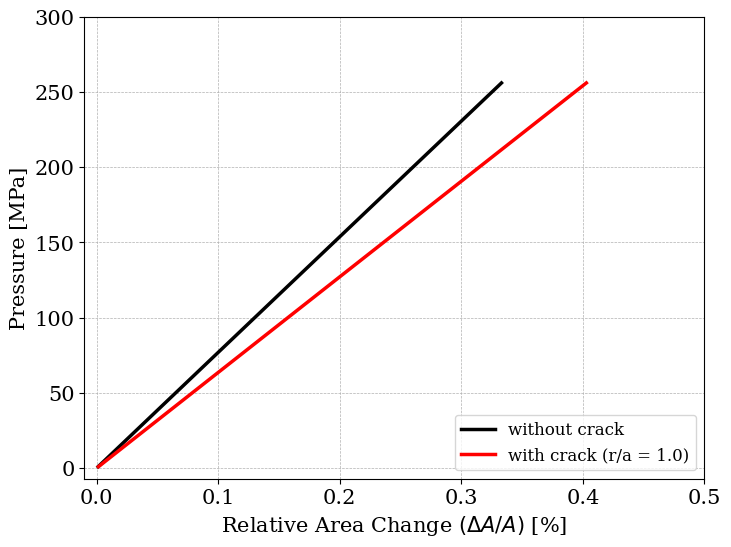

In [10]:
plt.figure(figsize=(8, 6))
# Create the plot
plt.plot(1e2*(area_th - np.pi*r**2)/(np.pi*r**2), p, color = 'black', linewidth = 2.5, label=f'without crack')
plt.plot(1e2*(area - area_ini)/area_ini, p, color = 'red', linewidth = 2.5, label=f'with crack (r/a = 1.0)')

# Add labels with LaTeX formatting
plt.xlabel(r'Relative Area Change $\left(\Delta A / A\right)$ [%]', fontsize=15)
plt.ylabel(r'Pressure [MPa]', fontsize=15)
# Increase the size of x and y labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Specify x and y limits with a specified number of ticks
plt.xlim(-0.01, 0.5)  # x limits
plt.ylim(-7, 300)       # y limits
plt.xticks(np.linspace(0.0, 0.5, 6))  # 5 ticks on x-axis
plt.yticks(np.linspace(0, 300, 7))      # 5 ticks on y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
legend_font = {'size': 'large', 'weight': 'normal'}
plt.legend(loc='lower right', prop=legend_font)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/combined_problem_crack_press_rel_area.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/combined_problem_crack_press_rel_area.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/combined_problem_crack_press_rel_area.eps', format='eps', dpi=300, bbox_inches='tight')